In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import glob
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [13]:
def attach_latlon(geo_ds, nav_ds):
    """
    Adds interpolated lat/lon coordinates to a geophysical dataset
    using navigation control points.
    """
    lat_ctl = nav_ds['latitude'].data
    lon_ctl = nav_ds['longitude'].data
    cols = nav_ds['cntl_pt_cols'].data  # pixel_control_points

    n_lines, n_pixels = geo_ds.dims['number_of_lines'], geo_ds.dims['pixels_per_line']

    lat_full = np.empty((n_lines, n_pixels), dtype=np.float32)
    lon_full = np.empty((n_lines, n_pixels), dtype=np.float32)

    for i in range(n_lines):
        f_lat = interp1d(cols, lat_ctl[i, :], bounds_error=False, fill_value="extrapolate")
        f_lon = interp1d(cols, lon_ctl[i, :], bounds_error=False, fill_value="extrapolate")
        lat_full[i, :] = f_lat(np.arange(n_pixels))
        lon_full[i, :] = f_lon(np.arange(n_pixels))

    geo_ds = geo_ds.assign_coords(
        lat=(('number_of_lines', 'pixels_per_line'), lat_full),
        lon=(('number_of_lines', 'pixels_per_line'), lon_full)
    )

    return geo_ds

def scatter_plot_var(ds, var_name, title=None, cmap='viridis', s=1):
    """
    Safe scatter plot of a geophysical variable using lat/lon.
    Only plots valid (finite) pixels.
    """
    var = ds[var_name]
    lat = ds['lat']
    lon = ds['lon']
    
    # Flatten everything
    lat_vals = lat.values.flatten()
    lon_vals = lon.values.flatten()
    data_vals = var.values.flatten()

    # Filter out NaNs
    mask = np.isfinite(lat_vals) & np.isfinite(lon_vals) & np.isfinite(data_vals)
    
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(lon_vals[mask], lat_vals[mask], c=data_vals[mask],
                     cmap=cmap, s=s, marker='.', alpha=0.8)
    plt.colorbar(sc, label=var.attrs.get('long_name', var_name))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title or var_name)
    plt.tight_layout()
    plt.show()

# Main function to load files and plot
def load_and_plot(nc_files, var_name='chlor_a', cmap='viridis'):
    """
    Loads a dataset, attaches lat/lon, and plots a specified variable.
    """
    # Open the first file to read the data
    geo_ds = xr.open_dataset(nc_files[0], group='geophysical_data')
    nav_ds = xr.open_dataset(nc_files[0], group='navigation_data')

    # Add lat/lon coordinates
    geo_ds = attach_latlon(geo_ds, nav_ds)

    # Plot the variable (e.g., 'chlor_a')
    scatter_plot_var(geo_ds, var_name, title=f'{var_name} Concentration', cmap=cmap)

In [ ]:
# --- Step 1. Load Your Dataset ---
# Use glob to recursively find all NetCDF files in ./data
nc_files = glob.glob(os.path.join('data', '**', '*.nc'), recursive=True)

geo_ds = xr.open_dataset(nc_files[0])

print(f"Found {len(nc_files)} NetCDF files.")

Found 41 NetCDF files.


C:\Users\Makai\AppData\Local\Temp\ipykernel_36292\3601619978.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_lines, n_pixels = geo_ds.dims['number_of_lines'], geo_ds.dims['pixels_per_line']


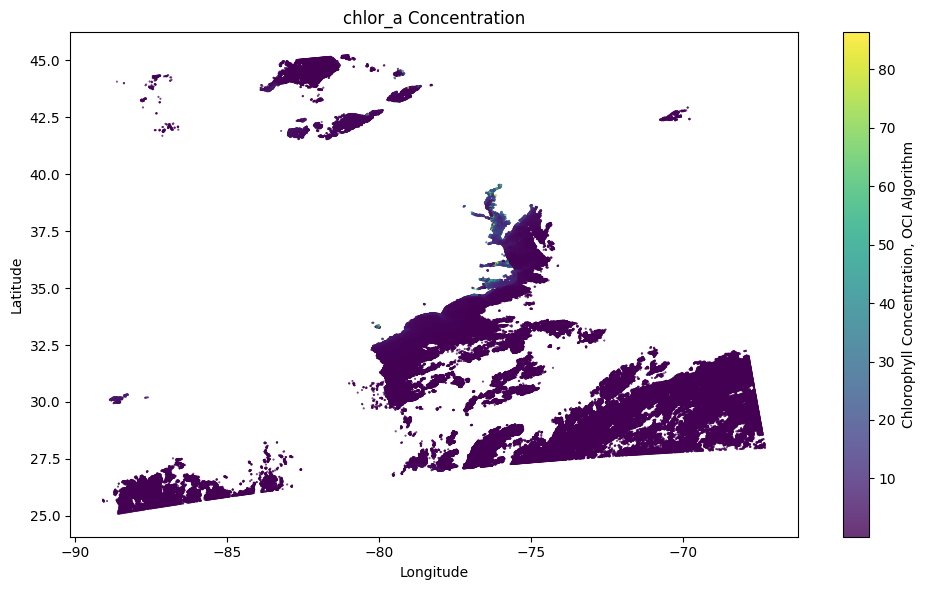

In [ ]:
load_and_plot(nc_files, var_name='chlor_a', cmap='viridis')